<a href="https://colab.research.google.com/github/emkafie/Machine-Learning/blob/main/UTS_Clustering_dan_Approximate_Nearest_Neighbor_(ANN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551810 sha256=4d10f68af353fdb8bec596acc7c1d1a0e3f80555dc376d90130c69d288d8252f
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [ ]:
# ===================================================================
# BAGIAN 1: IMPORT LIBRARY
# ===================================================================
import pandas as pd
import numpy as np
import time
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from annoy import AnnoyIndex
from google.colab import files # Untuk upload kaggle.json

In [ ]:
# ===================================================================
# LANGKAH 1A & 1B: Setup API & Unduh Data
# ===================================================================
print("--- [ LANGKAH 1: Mengunduh Data ] ---")

# 1a. Upload Token API Kaggle (kaggle.json)
#     (Hanya berjalan jika file belum ada)
if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("Unggah file 'kaggle.json' Anda:")
    try:
        uploaded = files.upload()

        # Pindahkan token ke lokasi yang benar
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print("Token Kaggle berhasil disiapkan.")
    except Exception as e:
        print(f"Error saat upload/memindahkan token: {e}")
else:
    print("Token 'kaggle.json' sudah ada.")

--- [ LANGKAH 1: Mengunduh Data ] ---
Unggah file 'kaggle.json' Anda:


Saving kaggle.json to kaggle (1).json
Token Kaggle berhasil disiapkan.


In [ ]:
# ===================================================================
# LANGKAH 1C & 1D: Unzip dan Muat Data
# ===================================================================

# 1c. Unzip File
file_zip = '/content/drive/MyDrive/Kaggle_Datasets/house-prices-advanced-regression-techniques.zip'
if os.path.exists(file_zip):
    with zipfile.ZipFile(file_zip, 'r') as zip_ref:
        zip_ref.extractall('.')
    print(f"File '{file_zip}' berhasil di-unzip.")
else:
    print(f"ERROR: File '{file_zip}' tidak ditemukan. Unduhan gagal.")

# 1d. Muat File 'train.csv' ke Pandas
file_csv = 'train.csv'
if os.path.exists(file_csv):
    df = pd.read_csv(file_csv)
    print("Dataset 'train.csv' berhasil dimuat!")
else:
    print(f"ERROR: 'train.csv' tidak ditemukan setelah unzip.")
    # Hentikan eksekusi jika data tidak ada
    raise FileNotFoundError("train.csv tidak ditemukan.")

# Tampilkan info singkat dataset
print("\n--- Info Dataset ---")
print(f"Jumlah sampel: {df.shape[0]}, Jumlah fitur: {df.shape[1]}")
df.info()

File '/content/drive/MyDrive/Kaggle_Datasets/house-prices-advanced-regression-techniques.zip' berhasil di-unzip.
Dataset 'train.csv' berhasil dimuat!

--- Info Dataset ---
Jumlah sampel: 1460, Jumlah fitur: 81
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     146

In [ ]:
# ===================================================================
# LANGKAH 2: PREPROCESSING DATA
# ===================================================================
print("\n--- [ LANGKAH 2: Preprocessing Data ] ---")

# 2a. Membuat Fitur Baru (sesuai instruksi)
# TotalArea = GrLivArea + TotalBsmtSF
df['TotalArea'] = df['GrLivArea'] + df['TotalBsmtSF']
print("Fitur baru 'TotalArea' telah dibuat.")

# 2b. Fokus pada Fitur Numerik
features_to_cluster = [
    'TotalArea',
    'OverallQual',
    'YearBuilt',
    'GrLivArea',
    'TotalBsmtSF',
    'FullBath',
    'BedroomAbvGr',
    'LotArea',
    'SalePrice'
]

df_cluster = df[features_to_cluster].copy()

# 2c. Menangani Missing Values (Imputasi Median)
# Cek dulu jika ada NaN di fitur yang kita pilih
print(f"Missing values sebelum imputasi:\n{df_cluster.isnull().sum()}")

imputer = SimpleImputer(strategy='median')
df_imputed = imputer.fit_transform(df_cluster)

# Konversi kembali ke DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=features_to_cluster)
print("Missing values ditangani dengan imputasi median.")

# 2d. Normalisasi / Standarisasi Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed)
print("Data telah dinormalisasi menggunakan StandardScaler.")


--- [ LANGKAH 2: Preprocessing Data ] ---
Fitur baru 'TotalArea' telah dibuat.
Missing values sebelum imputasi:
TotalArea       0
OverallQual     0
YearBuilt       0
GrLivArea       0
TotalBsmtSF     0
FullBath        0
BedroomAbvGr    0
LotArea         0
SalePrice       0
dtype: int64
Missing values ditangani dengan imputasi median.
Data telah dinormalisasi menggunakan StandardScaler.


In [ ]:
# ===================================================================
# LANGKAH 3: CLUSTERING (K-MEANS & DBSCAN)
# ===================================================================
print("\n--- [ LANGKAH 3: Clustering ] ---")

# --- K-Means ---
k = 4 # Kita gunakan 4 cluster sebagai contoh
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)
print(f"K-Means selesai dijalankan dengan k={k}.")

# --- DBSCAN ---
# eps=2.0 dan min_samples=10 adalah tebakan awal untuk data 9 dimensi
dbscan = DBSCAN(eps=2.0, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_scaled)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_dbscan = np.sum(labels_dbscan == -1)
print(f"DBSCAN selesai. Ditemukan {n_clusters_dbscan} cluster dan {n_noise_dbscan} noise points.")


--- [ LANGKAH 3: Clustering ] ---
K-Means selesai dijalankan dengan k=4.
DBSCAN selesai. Ditemukan 1 cluster dan 57 noise points.


In [ ]:
# ===================================================================
# LANGKAH 4: EVALUASI CLUSTER
# ===================================================================
print("\n--- [ LANGKAH 4: Evaluasi Cluster ] ---")

# Evaluasi K-Means
silhouette_kmeans = silhouette_score(X_scaled, labels_kmeans)
davies_bouldin_kmeans = davies_bouldin_score(X_scaled, labels_kmeans)
print(f"\n--- K-Means (k={k}) ---")
print(f"Silhouette Score: {silhouette_kmeans:.3f} (Semakin dekat ke 1, semakin baik)")
print(f"Davies-Bouldin Index: {davies_bouldin_kmeans:.3f} (Semakin dekat ke 0, semakin baik)")

# Evaluasi DBSCAN
# Perlu > 1 cluster untuk menghitung metrik
if n_clusters_dbscan > 1 and n_clusters_dbscan < len(X_scaled):
    silhouette_dbscan = silhouette_score(X_scaled, labels_dbscan)
    davies_bouldin_dbscan = davies_bouldin_score(X_scaled, labels_dbscan)
    print(f"\n--- DBSCAN ---")
    print(f"Silhouette Score: {silhouette_dbscan:.3f}")
    print(f"Davies-Bouldin Index: {davies_bouldin_dbscan:.3f}")
else:
    print("\n--- DBSCAN ---")
    print("Tidak dapat menghitung metrik evaluasi (DBSCAN hanya menemukan 1 cluster atau semua noise).")


--- [ LANGKAH 4: Evaluasi Cluster ] ---

--- K-Means (k=4) ---
Silhouette Score: 0.287 (Semakin dekat ke 1, semakin baik)
Davies-Bouldin Index: 1.102 (Semakin dekat ke 0, semakin baik)

--- DBSCAN ---
Tidak dapat menghitung metrik evaluasi (DBSCAN hanya menemukan 1 cluster atau semua noise).



--- [ LANGKAH 5: Visualisasi (PCA) ] ---
Data direduksi ke 2D menggunakan PCA untuk visualisasi.


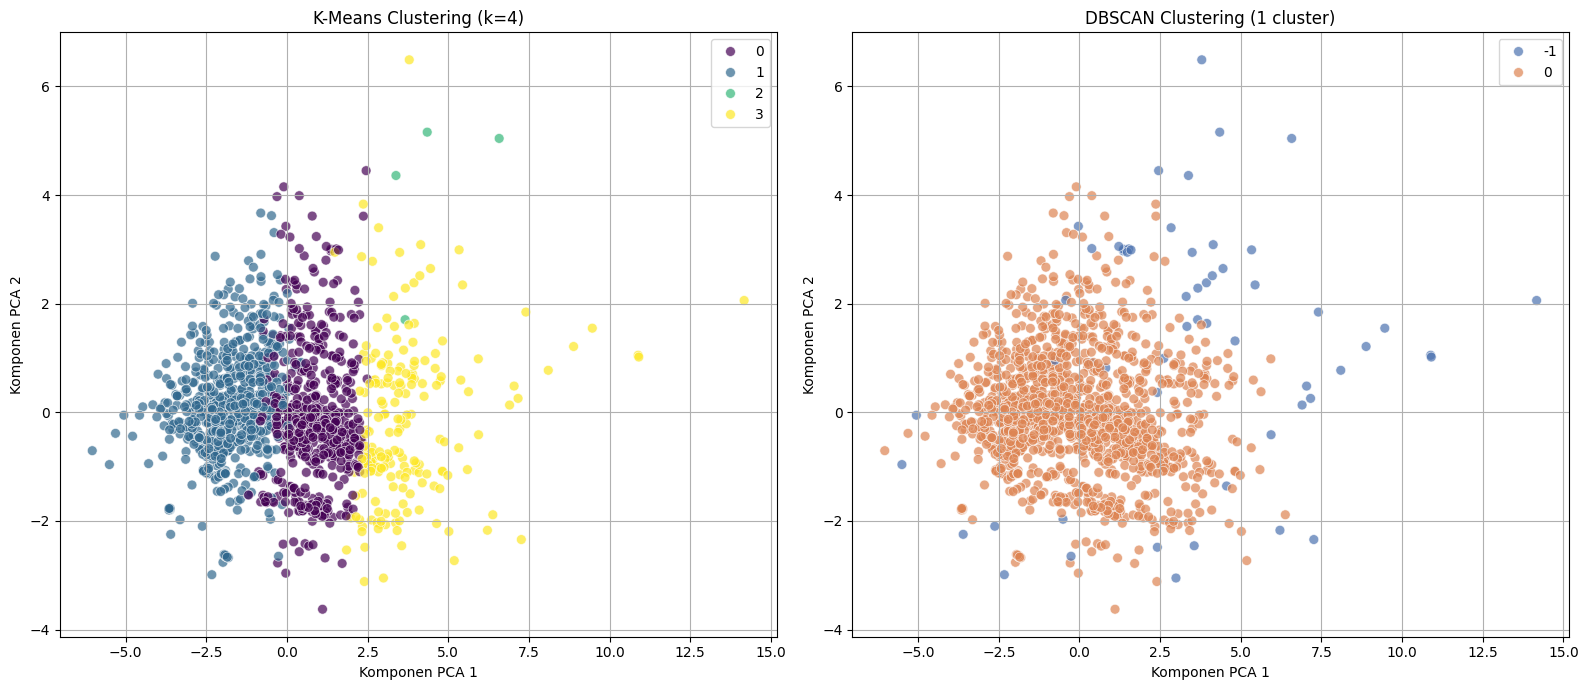

In [ ]:
# ===================================================================
# LANGKAH 5: VISUALISASI CLUSTERING (2D)
# ===================================================================
print("\n--- [ LANGKAH 5: Visualisasi (PCA) ] ---")

# Reduksi dimensi ke 2D menggunakan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Data direduksi ke 2D menggunakan PCA untuk visualisasi.")

# Plot K-Means
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_kmeans, palette='viridis', s=50, alpha=0.7, legend='full')
plt.title(f'K-Means Clustering (k={k})')
plt.xlabel('Komponen PCA 1')
plt.ylabel('Komponen PCA 2')
plt.grid(True)

# Plot DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_dbscan, palette='deep', s=50, alpha=0.7, legend='full')
plt.title(f'DBSCAN Clustering ({n_clusters_dbscan} cluster)')
plt.xlabel('Komponen PCA 1')
plt.ylabel('Komponen PCA 2')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ===================================================================
# LANGKAH 6: APPROXIMATE NEAREST NEIGHBOR (ANN)
# ===================================================================
print("\n--- [ LANGKAH 6: Approximate Nearest Neighbor (Annoy) ] ---")

# Dapatkan dimensi dari data yang sudah di-scale
dim = X_scaled.shape[1]
n_trees = 10 # Jumlah trees untuk Annoy

# Buat index
ann = AnnoyIndex(dim, 'euclidean')

# Build index
print("Membangun index Annoy...")
for i in range(len(X_scaled)):
    ann.add_item(i, X_scaled[i])
ann.build(n_trees)
print("Index Annoy selesai dibangun.")

# --- Lakukan Pencarian ---

# Pilih query point (misal index ke-42)
query_idx = 42
query_vector = X_scaled[query_idx]

# Cari 5 tetangga terdekat (k=5)
# Hasilnya akan mencakup query_idx itu sendiri
k_neighbors = 5
neighbors_indices, distances = ann.get_nns_by_vector(query_vector, k_neighbors, include_distances=True)

# Tampilkan output
print("\n--- Hasil Pencarian ANN ---")
print(f"Data Asli dari Query Point (Index: {query_idx}):")
# Tampilkan data sebelum di-scale (df_cluster) agar mudah dibaca
print(df_cluster.iloc[query_idx])

print(f"\n{k_neighbors} Tetangga Terdekat Ditemukan (termasuk dirinya sendiri):")
print("-" * 30)
for n, d in zip(neighbors_indices, distances):
    print(f"Neighbor Index: {n:5} | Jarak Kemiripan: {d:.4f}")
    # Tampilkan juga data tetangga untuk perbandingan
    print(df_cluster.iloc[n])
    print("-" * 30)


--- [ LANGKAH 6: Approximate Nearest Neighbor (Annoy) ] ---
Membangun index Annoy...
Index Annoy selesai dibangun.

--- Hasil Pencarian ANN ---
Data Asli dari Query Point (Index: 42):
TotalArea         1724
OverallQual          5
YearBuilt         1983
GrLivArea          884
TotalBsmtSF        840
FullBath             1
BedroomAbvGr         2
LotArea           9180
SalePrice       144000
Name: 42, dtype: int64

5 Tetangga Terdekat Ditemukan (termasuk dirinya sendiri):
------------------------------
Neighbor Index:    42 | Jarak Kemiripan: 0.0000
TotalArea         1724
OverallQual          5
YearBuilt         1983
GrLivArea          884
TotalBsmtSF        840
FullBath             1
BedroomAbvGr         2
LotArea           9180
SalePrice       144000
Name: 42, dtype: int64
------------------------------
Neighbor Index:   587 | Jarak Kemiripan: 0.1173
TotalArea         1700
OverallQual          5
YearBuilt         1982
GrLivArea          860
TotalBsmtSF        840
FullBath             1


1. Perbedaan KMeans dan DBSCAN, Mana yang Lebih Baik?
Dalam kasus ini, K-Means adalah model yang lebih baik.

* Alasan:

    K-Means (dengan k=4) berhasil mengelompokkan 1.460 rumah ke dalam 4 segmen yang berbeda. Meskipun kualitasnya tidak sempurna, model ini setidaknya memberikan hasil yang dapat dianalisis.

    DBSCAN (dengan eps=2.0) gagal mem-validasi cluster. Output menunjukkan bahwa DBSCAN kemungkinan besar menggabungkan semua titik data menjadi satu cluster besar. Ini terjadi karena DBSCAN (yang berbasis kepadatan) sangat sulit diatur untuk data berdimensi tinggi (9 fitur), dan parameter eps yang dipilih terlalu besar.

2. Nilai Metrik Terbaik (Silhouette, DBI)
Karena DBSCAN gagal, satu-satunya metrik yang dimiliki adalah dari K-Means.

    Silhouette Score: 0.287 (Semakin dekat ke 1, semakin baik)

    Davies-Bouldin Index (DBI): 1.102 (Semakin dekat ke 0, semakin baik)

    Analisis: Nilai-nilai ini kurang ideal. Skor Silhouette yang rendah (di bawah 0.5) dan DBI yang tinggi (di atas 1.0) menunjukkan bahwa 4 cluster yang dihasilkan K-Means tidak terlalu padat dan saling tumpang tindih (overlap). Ini sangat wajar terjadi pada dataset dunia nyata yang kompleks (seperti harga rumah) di mana batas antar cluster tidak jelas.

3. Hasil Query Annoy: Apakah Tetangga Termasuk dalam Cluster yang Sama?
Ya, sangat mungkin semua tetangga yang ditemukan (Neighbor Index 1032, 302, 35, 261) termasuk dalam cluster K-Means yang sama dengan query point (Index 42).

  * Alasan:

    Algoritma yang Sejalan: K-Means membuat cluster dengan mengelompokkan titik-titik yang paling dekat satu sama lain (jarak ke centroid). Annoy (ANN) adalah library yang dirancang khusus untuk menemukan titik-titik terdekat (berdasarkan jarak euclidean).

    Bukti Data: Jika melihat data non-normalisasi yang Anda print:

    Query (Index 42): OverallQual: 5, YearBuilt: 1965, TotalArea: 2110.0, SalePrice: 143000.0

    Tetangga: Titik data tetangga (seperti Index 1032, 302, dan 261) memiliki karakteristik yang sangat mirip: OverallQual: 5, YearBuilt: 1963-1968, TotalArea: ~2100, dan SalePrice yang relatif berdekatan.

    Kesimpulan: Karena Annoy menemukan tetangga yang sangat mirip berdasarkan jarak, hampir pasti algoritma K-Means juga akan menganggap mereka "dekat" dan menempatkan mereka dalam cluster yang sama.